# Hierarchical Modeling 

For a better `class` definition see [pymc3 example](https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/probabilistic_matrix_factorization.html).

For a tutorial on Hierarchical check out these tutorials from the `pymc3` examples page: 
  - https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-simpsons-paradox.html
  - https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/rugby_analytics.html
  
For more background about hierarchical Modeling, see these tutorials: 
  - https://twiecki.io/blog/2014/03/17/bayesian-glms-3/
  - https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/

Right now, each posterior predicted per glacier is independent of one another. This isn't the most efficient, nor the most bayesian. We should implement something that's properly hierarchical, but that will mean some reparameterization: 
  - https://stackoverflow.com/questions/48184335/userwarning-pymc3-what-does-reparameterize-mean


In terms of better priors, see: 
  - [Rounce et al. 2020](https://www-cambridge-org.proxy.lib.sfu.ca/core/services/aop-cambridge-core/content/view/61D8956E9A6C27CC1A5AEBFCDADC0432/S0022143019000911a.pdf/quantifying_parameter_uncertainty_in_a_largescale_glacier_evolution_model_using_bayesian_inference_application_to_high_mountain_asia.pdf): _Quantifying parameter uncertainty in a large-scale glacier evolution model using Bayesian
inference: application to High Mountain Asia_
 
From [Braithwaite 2008](https://www-cambridge-org.proxy.lib.sfu.ca/core/services/aop-cambridge-core/content/view/6C2362F61B7DE7F153247A039736D54C/S0022143000207636a.pdf/temperature-and-precipitation-climate-at-the-equilibrium-line-altitude-of-glaciers-expressed-by-the-degree-day-factor-for-melting-snow.pdf) we have sense of the prior distribution for the degree day factor for snow. Now the challenge for the hierarchical modeling is to find a way to minic said distibution as a "parent population" and model the deviation from that parent population for each glacier. 


In [1]:
import PDD
import glob
import numpy as np 
import pymc3 as pm 
import arviz as az
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

In [2]:
# Load the Young et al. 2020
Young2020 = xr.open_dataset("../MB_tune/notebooks/Young_etal_2020_Delta_T_-0.9_C.nc")
z_ref     = Young2020.stack(z=('x', 'y')).Elevation.mean().values
A_mean    = Young2020.stack(z=('x', 'y')).Accumulation.mean().values

In [3]:
# dictionary of PDD model parameters
const =  dict(T_m    = 0.0, 
              T_rs   = 1.0,
              A_mean = 1.4 * 910., 
              α      = 10.5, 
              T_ma   = -6.65,
              ΔTΔz   = 6.5E-3, 
              T_p    = 196, 
              ref_z  = 2193)

# initialize the PDD melt model class
melt_model = PDD.PDD_melt_model(**const)

In [4]:
# load the individual model runs
glacs = [('lilk-a',   '00.1'), 
         ('crmpt18-a','00.2'), 
         ('crmpt12',   -0.3)]

results_fp = "../../initialization/coarse/result/{}/nc/{}_*_{}_OFF*.nc"



dfs = []
for glac in glacs: 
    key, offset = glac
    
    src_fp = glob.glob(results_fp.format(*[key] * 2, offset))[0]
    
    with xr.open_dataset(src_fp) as src: 
        # correct for minimum ice thickness
        src["depth"] = xr.where(src.depth <= 10, 0, src.depth)
        # apply sigma coordinate transform for vertical coordinate
        src["Z"]     = src.zbed + src.Z * src.height 
        # Calculate the magnitude of the velocity vectors
        src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)    
        
    # Exract data of interest from NetCDF file
    z  = src['zs'].isel(t=-1,coord_2=-1).values[np.newaxis, :]
    MB = np.random.normal(src['zs accumulation flux 2'].isel(t=-1,coord_2=-1).values, 1e-1)[np.newaxis, :]
        
    dfs.append(pd.DataFrame({f'z':z[0], "MB": MB[0], 'key':[key]*len(z[0])}))
        
Elmer_Runs = pd.concat(dfs, ignore_index=True)
Elmer_Runs["key_factor"] =  pd.factorize(Elmer_Runs.key)[0]

coords = {"key": Elmer_Runs.key.unique(),
          "idx": np.arange(Elmer_Runs.shape[0])}

In [59]:
# Define "data", which allows hierarchical prediction
with pm.Model(coords=coords) as model: 
    # constant model encapsulated within pandas df
    MB = pm.Data("MB", Elmer_Runs["MB"], dims="idx")
    z  = pm.Data("z",  Elmer_Runs["z"],  dims="idx")
    g  = pm.Data("g",  Elmer_Runs["key_factor"],  dims="idx")
    
# Define Priors
with model: 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Mass balance Model (physical priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    #---------------------------
    # -> global model parameters
    #---------------------------
    # Somewhat base of Aschwanden et al. 2019
    C_prior = pm.TruncatedNormal("C",      mu=2.0,  sigma=1.0,  lower=1)
    # Need a reference for the accumulation grad distibution 
    grad_a  = pm.Uniform("grad_a", lower=1e-4, upper=1e-2)
    # Somewhat base of Aschwanden et al. 2019
    f_r_prior  = pm.TruncatedNormal('f_r',    mu=0.5,  sigma=0.5,  lower=0.0, upper=1)
    
    #----------------------------------------
    # -> hyperpriors (i.e. parent population)
    #----------------------------------------
    # Degree Day factor: hyperpriors
    f_s_sigma  = pm.HalfCauchy('f_s_sigma', 1)
    f_s_mu     = pm.TruncatedNormal("f_s_mu", 3.1, sigma = 1.5, lower=0.0)
    
#     f_r_sigma  = pm.HalfCauchy('f_r_sigma', 0.25)
#     f_r_mu     = pm.TruncatedNormal("f_r_mu", 0.5, sigma = 0.25, lower=0.0)
    
    #-------------------------------------
    # -> glacier-specific model parameters
    #-------------------------------------
    # Degree Day factor: Braithwaite (2008) / Rounce et al. 2020
    f_s_offset = pm.Normal('f_s_offset', mu=0, sd=2, dims='key')
    f_s_prior  = pm.Deterministic("f_s", f_s_mu + f_s_offset )#* f_s_sigma)    
    
    
#     # Refreezing Factor: Somewhat base of Aschwanden et al. 2019
#     f_r_offset = pm.Bound(pm.Normal, lower=0.5)('f_r_offset', mu=0, sd=0.25, dims='key')
#     f_r_prior  = pm.Deterministic("f_r", f_r_mu + f_r_offset * f_r_sigma) 


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # We should probably account for the error associated with our 
    # mass balance model not able to actually fit the Young et al. results
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ????? 
    
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Hyperparameters (likelihood related priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    sigma = pm.HalfCauchy("sigma", 10, )    



with model: 
    mu = pm.Deterministic('mu', 
                          melt_model.tt_forward(z, f_s_prior[g], C_prior, grad_a, f_r_prior), 
#                           melt_model.tt_forward(z, f_s_prior[g], C_prior, grad_a, f_r_prior[g])
                          dims='idx')
    
# Define likelihood (function?)  
with model: 
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=MB, dims='idx')
    
# run inference: Sample   
with model: 
    
    # prior = pm.sample_prior_predictive()
    
    # obtain starting values via MAP
    # startvals = pm.find_MAP()
    
    trace = pm.sample(draws=1000, 
                      tune=2000, 
                      cores=2, 
                      return_inferencedata=True, 
                      target_accept=0.99);


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, f_s_offset, f_s_mu, f_s_sigma, f_r, grad_a, C]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 2639 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


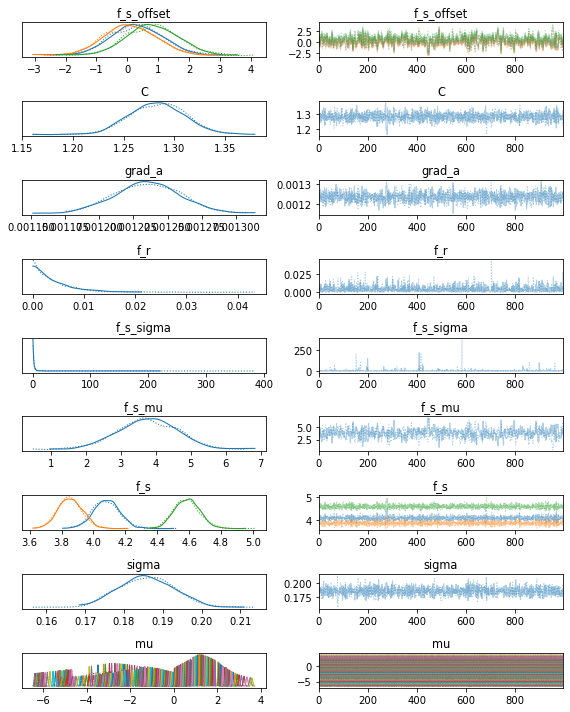

In [60]:
az.plot_trace(trace,
              figsize=(8,10));
plt.tight_layout()

In [61]:
with model: 
    ppc = pm.sample_posterior_predictive(
    trace, var_names=["f_s", "C", "grad_a", "f_r", "sigma", "Y_obs"])

In [62]:
def plot_parts(z, params, ax): 
    MB, A, R, M = melt_model.eval_forward(z, *params)
    
    ax.plot(z, A , alpha=0.1, c='#377eb8')
    ax.plot(z, R , alpha=0.1, c='#4daf4a')
    ax.plot(z, M , alpha=0.1, c='#984ea3')
    ax.plot(z, MB, alpha=0.1, c='#e41a1c')

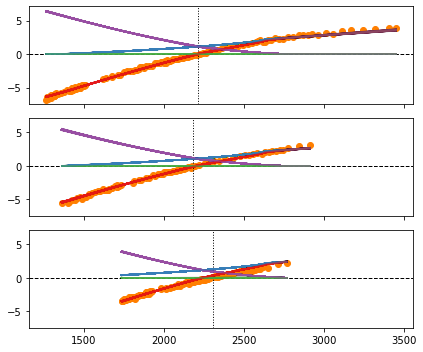

In [63]:
fig, ax = plt.subplots(3,1, figsize=(6,5),
                       sharex=True, sharey=True)

for j in [0,1,2]:
    sub_df = Elmer_Runs[Elmer_Runs['key_factor']==j]
    
    ELA_idx = np.argpartition(np.abs(sub_df.MB.values), 5)[:5]
    ELA = np.mean(sub_df.z.values[ELA_idx])

    ax[j].axhline(0,   ls="--", c='k', lw=1)
    ax[j].axvline(ELA, ls=":", c='k', lw=1)
    
    for i in np.random.randint(0,999,499):
        params = []
                
        for key in list(ppc)[:-2]: 
            if len(ppc[key].shape) == 2: 
                params.append(ppc[key][i, j])
            else: 
                params.append(ppc[key][i])
        
#         ax[j].plot(sub_df.z.values, 
#                    melt_model.eval_forward(sub_df.z.values, *params, parts=False), 
#                    c='tab:blue', 
#                    alpha=0.1)
        
        plot_parts(sub_df.z.values, params, ax[j])
 
    ax[j].scatter(sub_df.z, sub_df.MB, c='#ff7f00')
    


fig.tight_layout()
fig.savefig("/Users/andrewnolan/Desktop/test.pdf", bbox_inches='tight', facecolor='w')